# **TAREA 11 - VISIÓN DE MÁQUINA**

**Universidad Nacional de Colombia** <br>
**Maestría en Ingeniería - Automatización industrial**

Juan Sebastián Hernandez Reyes; Julián Felipe Molina Grisales

In [ ]:
#Importar las librerias necesarias
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics.pairwise import (chi2_kernel, laplacian_kernel,
                                      linear_kernel, polynomial_kernel,
                                      rbf_kernel, sigmoid_kernel)
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from sklearn.decomposition import KernelPCA, PCA
from sklearn.datasets import make_moons

## 1. Implementar, en python, el algoritmo para KDA.
---

---

El algoritmo de KDA es una combinación de 2 técnicas vistas para la reducción de dimensionalidad de los datos, en la cual se aplica una función de Kernel a los datos para pasarlos a un espacio de alta dimensionalidad, donde estos puedan ser separados adecuadamente, y luego se aplica el algoritmo de LDA en este espacio para separar estos de la mejor manera posible, se muestra en la sigueinte imagen

<center>
<img src = "https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/LI1/kda/kda.gif">
</center>

La implementación que sigue de este fue adaptada de [4] y sigue la convención usada en [5] y [6], la cual se puede resumir como:

*   Matriz de unos $\mathbf{1}$
*   Matriz de datos centrados $H := \mathbf{I} - \frac{1}{n_{samples}}\mathbf{1} \mathbf{1}^T$
*   Matriz de kernel $K$
*   Matriz doble centrada de kernel $C$
*   Matriz de datos transformados $Z$


Los otras variables en el código son parte del algoritmo, ademas que se coloca un parámetro de regularización que se ve representado en la variable ``Delta`` que es usada para evitar problemas númericos en la implementación.


In [ ]:
class KernelDiscriminantAnalysis(BaseEstimator, ClassifierMixin,
                                 TransformerMixin):
    """Kernel Discriminant Analysis.

    Parameters
    ----------
    lmb: float (>= 0.0), default=0.001
         Regularization parameter
    kernel: {"chi2", "laplacian", "linear", "polynomial", "rbf", "sigmoid"},
            default='rbf'
            Kernel.
    degree: integer, default=3
    gamma: float, default=None
    coef0: integer, default=1

    """

    def __init__(self, lmb=0.001, kernel='rbf', degree=3, gamma=None, coef0=1):
        self.lmb = lmb
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0

    def _kernel(self, X, Y=None):
        """Kernel"""
        kernel = None
        if self.kernel == 'chi2':
            kernel = chi2_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'laplacian':
            kernel = laplacian_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'linear':
            kernel = linear_kernel(X, Y)
        elif self.kernel == 'polynomial':
            kernel = polynomial_kernel(X, Y, degree=self.degree,
                                       gamma=self.gamma, coef0=self.coef0)
        elif self.kernel == 'rbf':
            kernel = rbf_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'sigmoid':
            kernel = sigmoid_kernel(X, Y, gamma=self.gamma, coef0=self.coef0)
        return kernel

    def fit(self, X, y):
        """Fit KDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           Training set.
        y: numpy array of shape [n_samples]
           Target values. Only works for 2 classes.

        Returns
        -------
        self

        """
        n = len(X)
        self._X = X
        self._H = np.identity(n) - 1 / n * np.ones(n) @ np.ones(n).T
        self._E = OneHotEncoder().fit_transform(y.reshape(n, 1))
        _, counts = np.unique(y, return_counts=True)
        K = self._kernel(X)
        C = self._H @ K @ self._H
        self._Delta = np.linalg.inv(C + self.lmb * np.identity(n))
        A = self._E.T @ C
        B = self._Delta @ self._E
        self._Pi_12 = np.diag(np.sqrt(1.0 / counts))
        P = self._Pi_12 @ A
        Q = B @ self._Pi_12
        R = P @ Q
        V, Gamma, self._U = np.linalg.svd(R, full_matrices=False)
        return self

    def transform(self, X):
        """Transform data with the trained KFDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           The input data.

        Returns
        -------
        y_pred: array-like, shape (n_samples, targets_shape)
                Transformations for X.

        """
        _K = self._kernel(X, self._X)
        K = _K - np.mean(_K, axis=0)
        C = self._H @ K.T
        T = self._U @ self._Pi_12 @ self._E.T @ self._Delta
        Z = T @ C
        return Z.T

## 2. Evaluar los algoritmos PCA, LDA, KPCA y KDA, en la reducción de la dimensión de los vectores de características de su proyecto.
---

---

Para probar los diferentes algoritmos de reducción de dimensionalidad, se hace uso de las funciones predefinidas en scikit-learn y el Iris Dataset, el cual es un dataset de clasificación de taxologia de flores presentado en Ronald Fisher en 1936, muy famoso en la comunidad de Machine Learning

In [ ]:
#Importando un dataset típico para hacer reducción de dimensionalidad
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separando los valores del dataset
X = df.loc[:, features].values
# Separando los valores del target
y = df.loc[:,['target']].values
y = y.reshape(-1)

In [ ]:
# Estandarización de los datos
X_scaled = StandardScaler().fit_transform(X)
df_standard = pd.DataFrame(X_scaled,columns=['sepal length','sepal width','petal length','petal width'])
df_standard.head()

,sepal length,sepal width,petal length,petal width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


### PCA

In [ ]:
#Implementando y aplicando el algoritmo PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

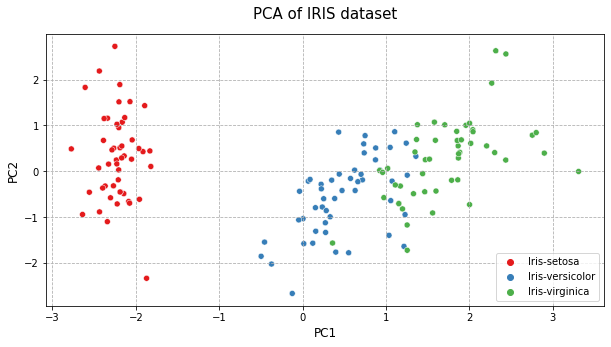

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue=y, palette='Set1')
ax.set_title("PCA of IRIS dataset", fontsize=15, pad=15)
ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.grid(linestyle='--')
plt.show()

### LDA

In [ ]:
#Implementando y aplicando el algoritmo LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

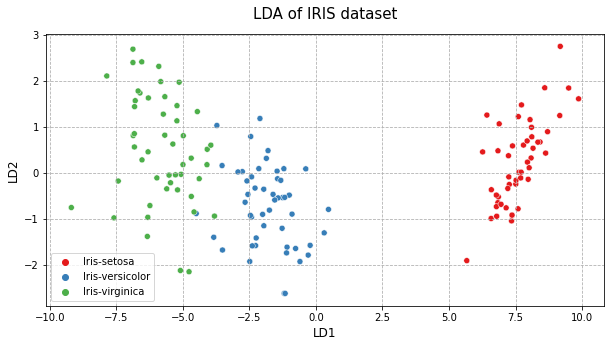

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
sns.scatterplot(x = X_lda[:,0], y = X_lda[:,1], hue=y, palette='Set1')
ax.set_title("LDA of IRIS dataset", fontsize=15, pad=15)
ax.set_xlabel("LD1", fontsize=12)
ax.set_ylabel("LD2", fontsize=12)
ax.grid(linestyle='--')
plt.show()

### Kernel - PCA

Los métodos de Kernel son especializados en la transformación de datos con una clasificación no lineal, en un espacio de de alta dimensionalidad donde sea linealmente separables. Para demostrar su capacidad de separación de datos no lineales ademas de usar el dataset Iris, se hara uso de un dataset de sintetico dado en la libreria ``skelarn`` de separación no lineal ``make_moons``

In [ ]:
#Implementando y aplicando el algoritmo KPCA usando 2 kernels en el dataset Iris
kpca1 = KernelPCA(n_components=2, kernel='rbf')
kpca2 = KernelPCA(n_components=2, kernel='poly')
X_kpca1 = kpca1.fit_transform(X_scaled)
X_kpca2 = kpca2.fit_transform(X_scaled)

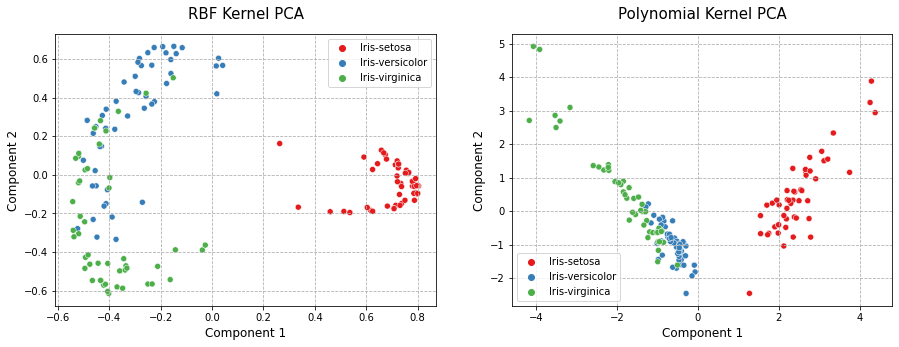

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15 ,5))
sns.scatterplot(x = X_kpca1[:, 0], y = X_kpca1[:, 1], hue=y, palette='Set1', ax=ax[0])
sns.scatterplot(x = X_kpca2[:, 0], y = X_kpca2[:, 1], hue=y, palette='Set1', ax=ax[1])
ax[0].set_title("RBF Kernel PCA", fontsize=15, pad=15)
ax[1].set_title("Polynomial Kernel PCA", fontsize=15, pad=15)
ax[0].set_xlabel("Component 1", fontsize=12)
ax[0].set_ylabel("Component 2", fontsize=12)
ax[1].set_xlabel("Component 1", fontsize=12)
ax[1].set_ylabel("Component 2", fontsize=12)
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
plt.show()

In [ ]:
#Generación de los datos de separación no lineal
Xt, yt = make_moons(n_samples=500)

#Implementando y aplicando el algoritmo KPCA 
kpca3 = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca3 = kpca3.fit_transform(Xt)

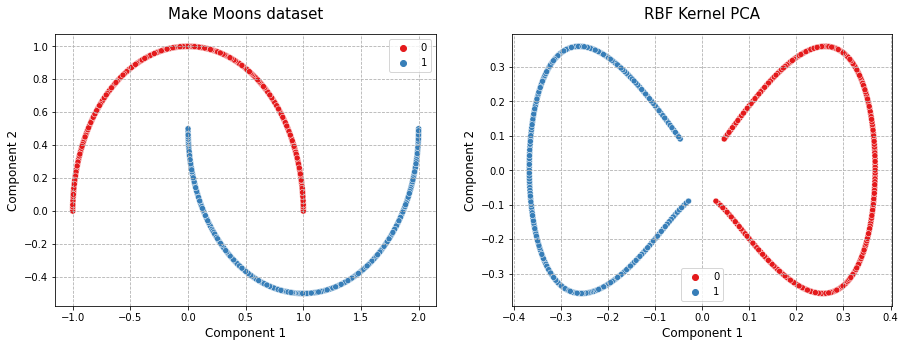

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15 ,5))
sns.scatterplot(x = Xt[:, 0], y = Xt[:, 1], hue=yt, palette='Set1', ax=ax[0])
sns.scatterplot(x = X_kpca3[:, 0], y = X_kpca3[:, 1], hue=yt, palette='Set1', ax=ax[1])
ax[0].set_title("Make Moons dataset", fontsize=15, pad=15)
ax[1].set_title("RBF Kernel PCA", fontsize=15, pad=15)
ax[0].set_xlabel("Component 1", fontsize=12)
ax[0].set_ylabel("Component 2", fontsize=12)
ax[1].set_xlabel("Component 1", fontsize=12)
ax[1].set_ylabel("Component 2", fontsize=12)
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
plt.show()

### KDA

In [ ]:
#Implementando y aplicando el algoritmo KDA 
kda = KernelDiscriminantAnalysis(kernel='rbf', gamma = 4)
kda = kda.fit(X_scaled, y)
X_kda = kda.transform(X_scaled)

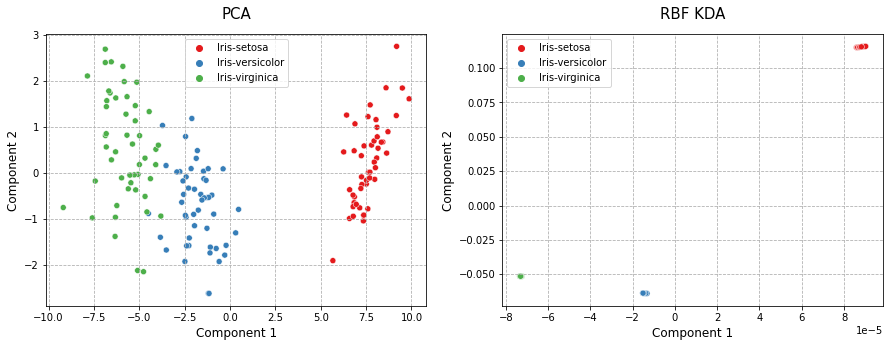

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15 ,5))
sns.scatterplot(x = X_lda[:, 0], y = X_lda[:, 1], hue=y, palette='Set1', ax=ax[0])
sns.scatterplot(x = X_kda[:, 0], y = X_kda[:, 1], hue=y, palette='Set1', ax=ax[1])
ax[0].set_title("PCA", fontsize=15, pad=15)
ax[1].set_title("RBF KDA", fontsize=15, pad=15)
ax[0].set_xlabel("Component 1", fontsize=12)
ax[0].set_ylabel("Component 2", fontsize=12)
ax[1].set_xlabel("Component 1", fontsize=12)
ax[1].set_ylabel("Component 2", fontsize=12)
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
plt.show()

In [ ]:
kda2 = KernelDiscriminantAnalysis(kernel='rbf')
X_kda2 = kda2.fit_transform(Xt,yt)

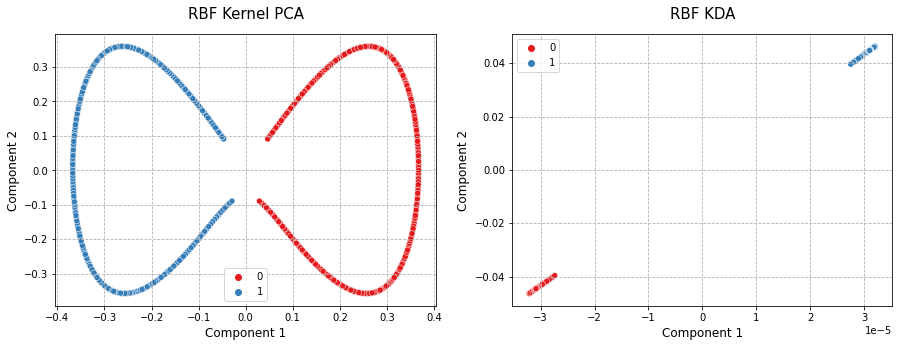

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15 ,5))
sns.scatterplot(x = X_kpca3[:, 0], y = X_kpca3[:, 1], hue=yt, palette='Set1', ax=ax[0])
sns.scatterplot(x = X_kda2[:, 0], y = X_kda2[:, 1], hue=yt, palette='Set1', ax=ax[1])
ax[0].set_title("RBF Kernel PCA", fontsize=15, pad=15)
ax[1].set_title("RBF KDA", fontsize=15, pad=15)
ax[0].set_xlabel("Component 1", fontsize=12)
ax[0].set_ylabel("Component 2", fontsize=12)
ax[1].set_xlabel("Component 1", fontsize=12)
ax[1].set_ylabel("Component 2", fontsize=12)
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
plt.show()

## Referencias

1.   Notas de clase y presentaciones. Visión de máquina. 2021-I.
2.   Pramoditha, Rukshan. 11 Dimensionality reduction techniques you should know in 2021. Medium. 2021. Available [here](https://towardsdatascience.com/11-dimensionality-reduction-techniques-you-should-know-in-2021-dcb9500d388b)
3.   Pramoditha, Rukshan. Image Compression Using 
Principal Component Analysis (PCA). Medium. 2021. Available [here](https://towardsdatascience.com/image-compression-using-principal-component-analysis-pca-253f26740a9f)

4. [Scikit-learn-compatible Kernel Discriminant Analysis](https://pypi.org/project/scikit-kda/)

5. Ghojogh, Benyamin. Karray, Fak. Crowley, Mark. Kernel Fisher Discriminant Analysis: Tutorial. 2019. arXiv. Available [here](https://arxiv.org/pdf/1906.09436.pdf)

6. Ghojogh, Benyamin. Crowley, Mark. Unsupervised and Supervised Principal Component Analysis: Tutorial. 2019. arXiv. Available [here](https://arxiv.org/pdf/1906.09436.pdf)
